In [1]:
import pandas as pd
import scipy
from scipy.stats import poisson
from scipy.stats import multinomial
from scipy.stats import norm
import warnings

import glob
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [3]:
path = "/home/felipe/JoaoPino/1-LQsCollider_project/Data_MadGraph/Full_data"

all_Signal = glob.glob(path + "/LQ_Tchannel_1p5TeV.csv")
all_ttbar = glob.glob(path + "/ttbar_*.csv")
all_WW = glob.glob(path + "/WW_*.csv")
all_ZZ = glob.glob(path + "/ZZ_*.csv")
all_ZW = glob.glob(path + "/ZW_*.csv")
all_Zplusjets = glob.glob(path + "/Z_plus_jets_*.csv")


In [4]:
li_Signal = []
li_ttbar = []
li_WW = []
li_ZZ = []
li_ZW = []
li_Zplusjets = []

#Signal
for filename in all_Signal:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_Signal.append(df)

Signal = pd.concat(li_Signal, axis=0, ignore_index=True)

#ttbar
for filename in all_ttbar:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ttbar.append(df)

ttbar = pd.concat(li_ttbar, axis=0, ignore_index=True)

#WW
for filename in all_WW:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_WW.append(df)

WW = pd.concat(li_WW, axis=0, ignore_index=True)

#ZZ
for filename in all_ZZ:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ZZ.append(df)

ZZ = pd.concat(li_ZZ, axis=0, ignore_index=True)

#ZW
for filename in all_ZW:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ZW.append(df)

ZW = pd.concat(li_ZW, axis=0, ignore_index=True)

#Z plus jets
for filename in all_Zplusjets:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_Zplusjets.append(df)

Z_plus_jets = pd.concat(li_Zplusjets, axis=0, ignore_index=True)

Diboson = pd.concat([WW, ZZ, ZW],axis=0)

In [5]:
#Reweight backgrounds to higher-order cross sections

#Cross sections: Sums all values in collumn 'weight' in each data frame
#Divided by the number of samples. I have batches of 10 samples, each with 100K events

#ttbar
ttbar_N3LO = 988.57
ttbar_LO = 93.32
ttbar_new_weight = (ttbar['xs_weight']*ttbar_N3LO)/ttbar_LO
xsec_N3LO_ttbar = (ttbar_new_weight.sum()*1000)/10

#Z plus jets
Zjets_NNLO = 6.33*1e4
Zjets_LO = 4128.0
Zjets_new_weight = (Z_plus_jets['xs_weight']*Zjets_NNLO)/Zjets_LO
xsec_NNLO_Zjets = (Zjets_new_weight.sum()*1000)/10

#VV +jets. Cross sections for each individual process 
#WW + jets
WW_NLO = 124.31
WW_LO = 77.22
WW_new_weight = (WW['xs_weight']*WW_NLO)/WW_LO
xsec_NNLO_WW = (WW_new_weight.sum()*1000)/10

#WZ + jets
ZW_NLO = 51.82
ZW_LO = 0.9827
ZW_new_weight = (ZW['xs_weight']*ZW_NLO)/ZW_LO
xsec_NNLO_ZW = (ZW_new_weight.sum()*1000)/10

#ZZ + jets
ZZ_NLO = 17.72
ZZ_LO = 0.03654
ZZ_new_weight = (ZZ['xs_weight']*ZZ_NLO)/ZZ_LO
xsec_NNLO_ZZ = (ZZ_new_weight.sum()*1000)/10


In [6]:
ttbar['xs_weight'] = ttbar_new_weight
Z_plus_jets['xs_weight'] = Zjets_new_weight
WW['xs_weight'] = WW_new_weight
ZW['xs_weight'] = ZW_new_weight
ZZ['xs_weight'] = ZZ_new_weight

Diboson = pd.concat([WW, ZZ, ZW],axis=0)

In [7]:
print("Available observables : \n\n {}".format(np.transpose(list(Diboson))))

Available observables : 

 ['pt_l1' 'pt_l2' 'E_l1' 'E_l2' 'eta_l1' 'eta_l2' 'phi_l1' 'phi_l2'
 'DeltaR_l1l2' 'DeltaPhi_l1l2' 'DeltaTheta_l1l2' 'DeltaEta_l1l2'
 'cos_l1l2' 'pt_l1_CM' 'pt_l2_CM' 'E_l1_CM' 'E_l2_CM' 'eta_l1_CM'
 'eta_l2_CM' 'phi_l1_CM' 'phi_l2_CM' 'DeltaR_l1l2_CM' 'DeltaPhi_l1l2_CM'
 'DeltaTheta_l1l2_CM' 'DeltaEta_l1l2_CM' 'cos_l1l2_CM' 'b2_l1l2' 'b4_l1l2'
 'M_l1l2' 'SpinCorr_Rcosl1' 'SpinCorr_Rcosl2' 'SpinCorr_Ncosl1'
 'SpinCorr_Ncosl2' 'mphi1' 'M_l1l2_CM' 'xs_weight']


In [8]:
number_of_bins = 30
Obs = 'pt_l2'
lumi = 3000.

Get_events_background_l1 = Diboson[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Diboson['xs_weight']*1000*lumi)))[0] + \
                     Z_plus_jets[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Z_plus_jets['xs_weight']*1000*lumi)))[0] + \
                     ttbar[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=ttbar['xs_weight']*1000*lumi)))[0]
Get_events_background_l1 = np.array([int(s) for s in Get_events_background_l1])

Get_events_signal_l1 = Signal[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Signal[Obs].max()), bins=number_of_bins, weights=Signal['xs_weight']*1000*lumi)))[0]
Get_events_signal_l1 = np.array([int(s) for s in Get_events_signal_l1])

print("Number of expected background events/bin: \n {}".format(Get_events_background_l1))
print("\n")
print("Number of expected signal events/bin: \n {}".format(Get_events_signal_l1))
print("\n")
print("Number of expected signal + background events \n {}".format(Get_events_background_l1 + Get_events_signal_l1))
print("\n")
print("Collider luminosity: {} fb^(-1)".format(lumi))
print("\n")
print("Distribution for the calculation {}".format(Obs))


Number of expected background events/bin: 
 [327136629345    592671953     60040522     11762895      3917947
      2392474       122270        77941        35675        17964
        10728         5234          531         3679          531
         2570            0            0         1553            0
            0            0            0            0            0
            0            0            0            0            0]


Number of expected signal events/bin: 
 [4621 5744 5366 4062 3589 2666 1872 1387  984  797  520  450  281  121
   69   86   60   30   47   26    8    0    4    0    0    4    0    0
    0    4]


Number of expected signal + background events 
 [327136633966    592677697     60045888     11766957      3921536
      2395140       124142        79328        36659        18761
        11248         5684          812         3800          600
         2656           60           30         1600           26
            8            0            4          

# Generate Poisson equivalent distributions for signal and backgrounds

In [9]:
Features = ['Log_prob_S', 'Log_prob_B']

df = pd.DataFrame(columns=Features)


#Number of pseudo experiments
N = 50_000

#Arrays with the number of background events and the number of signal+background events
Background = Get_events_background_l1
Signal_plus_background = Get_events_background_l1 + Get_events_signal_l1

#Up to which bins to use
number_of_bins = np.where(Get_events_background_l1 == 0)[0][0]

for idx in tqdm(range(0, N)):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
    
            # ----- Signal -----
            # Create new data that is poisson distributed based on the orignal simulated one
            New_events_signal = np.array([ np.random.poisson(Signal_plus_background[i]) for i in range(0, number_of_bins) ])

            # For the background, stay fixed
            New_events_background = Background

            # ----- Get probabilities ----- 
            Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,number_of_bins)])    
            Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,number_of_bins)])
            
            Get_product_S = np.prod(Get_probabilities_poisson_S)
            Get_product_B = np.prod(Get_probabilities_poisson_B)
            Get_prob_S = np.log(Get_product_S/Get_product_B)

            # ----- Background -----
            # Create new data that is poisson distributed based on the orignal simulated one
            New_events_background = np.array([ np.random.poisson(Background[i]) for i in range(0, number_of_bins) ])
            
            # For the signal, stay fixed
            New_events_signal = Signal_plus_background
            
            # ----- Get probabilities ----- 
            Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,number_of_bins)])    
            Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,number_of_bins)])
            
            Get_product_S = np.prod(Get_probabilities_poisson_S)
            Get_product_B = np.prod(Get_probabilities_poisson_B)            
            Get_prob_B = np.log(Get_product_S/Get_product_B)

            Obs = [Get_prob_S, Get_prob_B]

            # Save data data into a dataframe for further manipulation (df_S)
            entry = pd.DataFrame([Obs], columns=Features)
            df = df.append(entry)

        except Warning as e:
            continue
            

100%|██████████| 50000/50000 [02:57<00:00, 281.43it/s]


# Plots

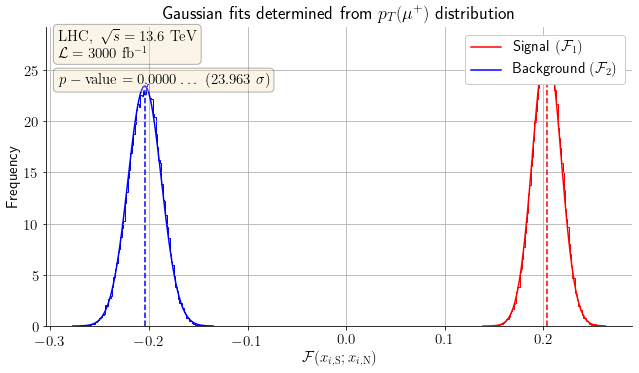

In [11]:
mpl.rcParams['text.usetex']=True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams.update({'font.size': 15})
mpl.rcParams["legend.framealpha"] = 1.0
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.figsize"] = [10.5, 5.5]

f, ax = plt.subplots()

#Get bins for gaussian fit
_, bins_S, _ = plt.hist(df['Log_prob_S'].to_numpy(), bins=100, density=1 , alpha=0.5)
_, bins_B, _ = plt.hist(df['Log_prob_B'].to_numpy(), bins=100, density=1 , alpha=0.5)
#Close so plots are not drawn
plt.clf()

#Signal plot
mu_S, sigma_S = scipy.stats.norm.fit(df['Log_prob_S'].to_numpy())
best_fit_line_S = scipy.stats.norm.pdf(bins_S, mu_S, sigma_S)
df['Log_prob_S'].hist(bins=100, color='red', histtype = 'step', density=True)
plt.plot(bins_S, best_fit_line_S, '-r')

#Background plot
mu_B, sigma_B = scipy.stats.norm.fit(df['Log_prob_B'].to_numpy())
best_fit_line_B = scipy.stats.norm.pdf(bins_B, mu_B, sigma_B)
df['Log_prob_B'].hist(bins=100, color='blue', histtype = 'step', density=True)
plt.plot(bins_B, best_fit_line_B, '-b')

#Calculate p-value and translate to sigmas
p_value = 1 - norm.cdf(mu_S, mu_B, sigma_B)
sigma = (mu_S - mu_B)/sigma_B


plt.legend([r'Signal $(\mathcal{F}_1)$', r'Background $(\mathcal{F}_2)$'], loc='upper right')
plt.grid("on")
plt.ylabel('Frequency')
plt.xlabel(r'$\mathcal{F}(x_{i,\mathrm{S}}; x_{i,\mathrm{N}})$')
plt.title(r'Gaussian fits determined from $p_T (\mu^+)$ distribution')
plt.plot(np.ones(100)*mu_S, np.linspace(0,max(best_fit_line_S),100), '--r')
plt.plot(np.ones(100)*mu_B, np.linspace(0,max(best_fit_line_B),100), '--b')
#plt.xlim(-0.54, 0.42)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.02, 0.90, '$\mathrm{{LHC}},~\sqrt{{s}} = 13.6~\mathrm{{TeV}}$ \n $\mathcal{{L}}={l}~\mathrm{{fb^{{-1}}}}$'.format(l=int(lumi)), transform=plt.gca().transAxes, bbox=props)
if p_value == 0.0:
    plt.text(0.02, 0.81, '$p-\mathrm{{value}} = 0.0000\dots~({0:.3f}~\sigma)$'.format(sigma), transform=plt.gca().transAxes, bbox=props)
elif p_value != 0.0:
    plt.text(0.02, 0.81, '$p-\mathrm{{value}} = {a}~({b}~\sigma)$'.format(a=latex_float(p_value), b=np.round(sigma,3)), transform=plt.gca().transAxes, bbox=props)
    
#plt.ylim(0, 200)    
#plt.show()
plt.savefig('/home/felipe/JoaoPino/1-LQsCollider_project/Plots/pT_mumu_3000fb_1p5TeV.pdf')